# Using Conformal Sets to Estimate False Positive Rates

By Andy Wheeler

Uses NIJ recidivism data as an example

In [1]:
from conformal_fp import ConfSet # needs a newer version of scipy for ecdf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# NIJ Recidivism data with some feature engineering
pdata = pd.read_csv('NIJRecid.csv') # NIJ recidivism data

# Train/test split and fit model
train = pdata[pdata['Training_Sample'] == 1]
test = pdata[pdata['Training_Sample'] == 0]

yvar = 'Recidivism_Arrest_Year1'
xvar = list(pdata)[2:]

# Random forest, need to set OOB to true
# for conformal (otherwise need to use a seperate calibration sample)
rf = RandomForestClassifier(max_depth=5,min_samples_leaf=100,random_state=10,n_estimators=1000,oob_score=True)
rf.fit(train[xvar],train[yvar])

# Out of bag predictions
probs = rf.oob_decision_function_
probs

array([[0.72943959, 0.27056041],
       [0.69507844, 0.30492156],
       [0.69035084, 0.30964916],
       ...,
       [0.88332402, 0.11667598],
       [0.8910954 , 0.1089046 ],
       [0.64774593, 0.35225407]])

In [2]:
# Can replicate metrics I showed in prior post
confRecid = ConfSet(train[yvar],probs[:,1])

print('Threshold for 95% recall')
cover95 = confRecid.Cover1(95)
print(cover95)

print('\nThreshold for 95% negative class recall')
print(confRecid.Cover0(95))

print(f'\nThis shows the stats for if you set the threshold to {cover95:,.2f}')
c0, c1, fp = confRecid.PCover(cover95)
                           
print(f'\nCover 0 Class {c0:,.2f}')
print(f'Cover 1 Class {c1:,.2f} (Recall)')
print(f'False Positve Rate {fp:,.2f}')

Threshold for 95% recall
0.1903596962366647

Threshold for 95% negative class recall
0.4339807339364077

This shows the stats for if you set the threshold to 0.19

Cover 0 Class 0.20
Cover 1 Class 0.95 (Recall)
False Positve Rate 0.66


In [3]:
# Now can look at our predictions vs what happens
ptest = rf.predict_proba(test[xvar])
t1 = test[yvar] == 1
t0 = test[yvar] == 0

obsC0 = (ptest[t0,1] < cover95).mean()
obsC1 = (ptest[t1,1] > cover95).mean()
obsFP = 1 - test[yvar][ptest[:,1] > cover95].mean()

pred = [float(c0),float(c1),fp]
obs = [obsC0,obsC1,obsFP]
df = pd.DataFrame(zip(pred,obs),columns=['Predicted','Observed'], index=['Cover0','Recall','FP Rate'])
print(f'Predicted vs Observed Out of Sample at Threshold {cover95:,.2f}')
df.round(3)

Predicted vs Observed Out of Sample at Threshold 0.19


,Predicted,Observed
Cover0,0.203,0.199
Recall,0.950,0.951
FP Rate,0.664,0.662


In [4]:
# Can check out the results across a range of thresholds
pl = np.arange(0.1,0.51,0.01)
predC0, predC1, predFP = confRecid.PCover(pl)

res = []

for p in pl:
    fprate = 1 - test[yvar][ptest[:,1] > p].mean()
    cover1 = (ptest[t1,1] > p).mean()
    cover0 = (ptest[t0,1] < p).mean()
    res.append([cover0,cover1,fprate])

resDf = pd.DataFrame(res,columns=['OC0','OC1','OFP'])
resDf['Threshold'] = pl
resDf['PC0'] = predC0
resDf['PC1'] = predC1
resDf['PFP'] = predFP
resDf = resDf[['Threshold','PC0','OC0','PC1','OC1','PFP','OFP']]
print('P Variables are predicted and O variables are observed')
resDf.round(3)

P Variables are predicted and O variables are observed


,Threshold,PC0,OC0,PC1,OC1,PFP,OFP
0,0.10,0.014,0.015,0.998,1.000,0.699,0.696
1,0.11,0.028,0.026,0.996,0.997,0.697,0.694
2,0.12,0.044,0.043,0.993,0.994,0.694,0.691
3,0.13,0.062,0.059,0.991,0.990,0.690,0.689
4,0.14,0.083,0.075,0.988,0.986,0.686,0.686
5,0.15,0.101,0.095,0.983,0.980,0.683,0.682
6,0.16,0.124,0.115,0.976,0.976,0.679,0.678
7,0.17,0.148,0.143,0.970,0.968,0.674,0.673
8,0.18,0.174,0.174,0.961,0.962,0.669,0.666
9,0.19,0.203,0.199,0.950,0.951,0.664,0.662


<AxesSubplot: xlabel='Threshold'>

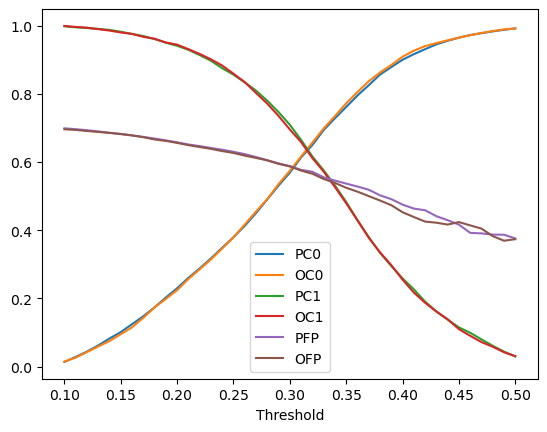

In [5]:
# I am lazy to make this nice, but here is the plot of these
# metrics to show visually they match in out of sample very
# closely

dfr = resDf.set_index('Threshold')
dfr.plot()